In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import sklearn
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.utils import resample


In [2]:
#load data

df = pd.read_csv(r"C:\Users\mmull\OneDrive\Documents\MSDS\ML Supervised Project\animal-shelter-intakes-and-outcomes.csv")
print('Shape: ', df.shape)
print('Features: ', df.columns)
df.dtypes

Shape:  (9679, 23)
Features:  Index(['Animal ID', 'Animal Name', 'Animal Type', 'Primary Color',
       'Secondary Color', 'Sex', 'DOB', 'Intake Date', 'Intake Condition',
       'Intake Type', 'Intake Subtype', 'Reason for Intake', 'Outcome Date',
       'Crossing', 'Jurisdiction', 'Outcome Type', 'Outcome Subtype',
       'latitude', 'longitude', 'intake_is_dead', 'outcome_is_dead',
       'was_outcome_alive', 'geopoint'],
      dtype='object')


Animal ID             object
Animal Name           object
Animal Type           object
Primary Color         object
Secondary Color       object
Sex                   object
DOB                   object
Intake Date           object
Intake Condition      object
Intake Type           object
Intake Subtype        object
Reason for Intake     object
Outcome Date          object
Crossing              object
Jurisdiction          object
Outcome Type          object
Outcome Subtype       object
latitude             float64
longitude            float64
intake_is_dead        object
outcome_is_dead         bool
was_outcome_alive      int64
geopoint              object
dtype: object

In [3]:
#change date columns to date datatype

df = df.astype({'DOB': 'datetime64[ns]', 'Intake Date': 'datetime64[ns]', 'Outcome Date': 'datetime64[ns]'})

In [4]:
#add new columns ('Age on Intake', 'Time in Shelter')
df['Age on Intake'] = (df['Intake Date'] - df['DOB'])/ np.timedelta64(1, 'D')
df['Time in Shelter'] = (df['Outcome Date'] - df['Intake Date'])/ np.timedelta64(1, 'D')


In [5]:
df.dtypes

Animal ID                    object
Animal Name                  object
Animal Type                  object
Primary Color                object
Secondary Color              object
Sex                          object
DOB                  datetime64[ns]
Intake Date          datetime64[ns]
Intake Condition             object
Intake Type                  object
Intake Subtype               object
Reason for Intake            object
Outcome Date         datetime64[ns]
Crossing                     object
Jurisdiction                 object
Outcome Type                 object
Outcome Subtype              object
latitude                    float64
longitude                   float64
intake_is_dead               object
outcome_is_dead                bool
was_outcome_alive             int64
geopoint                     object
Age on Intake               float64
Time in Shelter             float64
dtype: object

In [6]:
#remove columns
#'Reason for Intake' because there were 8542 null values
#'was_outcome_alive' because redundant with 'outcome_is_dead'
#'intake_is_dead' because all values are alive
#'latitude' and 'longitude' because redundant with 'geopoint'
#'Animal Type' because all values are 'DOG'
#'Outcome Subtype because cannot be used to predict 'Outcome Type' (cannot be known before 'Outcome Type')
#'Animal Name' because too many values for it to have predictive values

df = df.drop(columns = ['Animal ID', 'Animal Name', 'Animal Type', 'Reason for Intake', 'was_outcome_alive', 'outcome_is_dead', 'intake_is_dead', 'latitude', 'longitude', 'Outcome Subtype', 'Crossing', 'Jurisdiction', 'geopoint'])

In [7]:
pd.isnull(df).sum()

Primary Color          0
Secondary Color     3828
Sex                    0
DOB                  176
Intake Date            0
Intake Condition       0
Intake Type            0
Intake Subtype       206
Outcome Date         150
Outcome Type         153
Age on Intake        176
Time in Shelter      150
dtype: int64

In [8]:
#remove rows
#remove rows with missing 'Outcome Type' because that is the target variable to be predicted
#remove very rare outcome types because there is insufficient data to predict them
df = df.dropna(subset = 'Outcome Type')
df = df.drop(df[df['Intake Type'] == 'Euthenasia Required'].index)
df = df.drop(df[df['Intake Type'] == 'Adopted Animal Return'].index)
df = df.drop(df[df['Outcome Type'] == 'FOSTER'].index)
df = df.drop(df[df['Outcome Type'] == 'MISSING'].index)
df = df.drop(df[df['Outcome Type'] == 'DIED'].index)
df = df.drop(df[df['Outcome Type'] == 'FOSTER TO ADOPT'].index)

df.shape

(9369, 12)

In [9]:
#impute missing data
#'Secondary Color' and 'Intake Subtype'- use mode of available data

df['Secondary Color'] = df['Secondary Color'].fillna(df['Secondary Color'].mode()[0])
df['Intake Subtype'] = df['Intake Subtype'].fillna(df['Intake Subtype'].mode()[0])


In [10]:
# impute unknown Sex, Age on Intake
df.loc[ df['Sex'] == 'Unknown', 'Sex'] = df['Sex'].mode()[0]
# median age
df['Age on Intake'] = df['Age on Intake'].fillna(df['Age on Intake'].median())

In [11]:
bins = [float('-inf'), 180, 1095, 2922, np.inf]
names = ['Puppy', 'Young', 'Adult', 'Senior']
df['Age Category'] = pd.cut(df['Age on Intake'], bins, labels = names, include_lowest = True)

In [12]:
pd.isnull(df).sum()

Primary Color         0
Secondary Color       0
Sex                   0
DOB                 168
Intake Date           0
Intake Condition      0
Intake Type           0
Intake Subtype        0
Outcome Date          0
Outcome Type          0
Age on Intake         0
Time in Shelter       0
Age Category          0
dtype: int64

In [13]:
df.describe()


DOB                    Intake Date  \
count                           9201                           9369   
mean   2016-06-24 06:58:48.399087104  2020-07-06 06:58:58.904899328   
min              1996-11-11 00:00:00            2017-01-01 00:00:00   
25%              2013-09-30 00:00:00            2018-06-19 00:00:00   
50%              2016-11-21 00:00:00            2020-01-15 00:00:00   
75%              2019-11-07 00:00:00            2022-11-19 00:00:00   
max              2024-07-05 00:00:00            2024-07-21 00:00:00   
std                              NaN                            NaN   

                        Outcome Date  Age on Intake  Time in Shelter  
count                           9369    9369.000000      9369.000000  
mean   2020-07-25 06:14:52.219020032    1458.390437        18.969367  
min              2017-01-01 00:00:00      -7.000000         0.000000  
25%              2018-07-03 00:00:00     365.000000         2.000000  
50%              2020-01-26 00:00:00    1095.000000         6.000000  
75%              2022-12-14 00:00:00    2187.000000        15.000000  
max              2024-07-24 00:00:00    7782.000000      1046.000000  
std                              NaN    1311.669255        45.694515

In [14]:
# Group similar colors together
# blue, silver, blk smoke, gray, liver, bl brindle, blue brind, blue merle, blue tick, liver tick
# apricot, orange, pink, buff, red, ruddy, tan, red merle, sable
# chocolate, brown, br brindle, brn merle, br tiger, seal
# blonde, cream, crm tiger, gold, fawn, wheat, yellow, y brindle
# brn tiger, br brindle
# brn merle, dapple
df.replace({'APRICOT': 'RED', 'BL BRINDLE': 'BLACK', 'BLK SMOKE': 'BLACK', 'BLONDE': 'GOLD', 'BLUE': 'SILVER', 'BLUE BRIND': 'SILVER', 'BLUE MERLE': 'SILVER',
           'BLUE TICK': 'SILVER', 'BR BRINDLE': 'BROWN', 'BRN MERLE': 'BROWN', 'BRN TIGER': 'BROWN', 'BUFF': 'RED', 'CHOCOLATE': 'BROWN',
           'CREAM': 'GOLD', 'CRM TIGER': 'GOLD', 'DAPPLE': 'SILVER', 'FAWN': 'GOLD', 'GRAY': 'SILVER', 'LIVER': 'SILVER', 'LIVER TICK': 'SILVER',
           'ORANGE': 'RED', 'PINK': 'RED', 'RED MERLE': 'RED', 'RUDDY': 'RED', 'SABLE': 'RED', 'SEAL': 'BROWN', 'TAN': 'RED', 'WHEAT': 'GOLD',
           'Y BRINDLE': 'GOLD', 'YELLOW': 'GOLD', 'PURPLE': None}, inplace = True)


In [15]:
# Combine similar values
# Homefirst is a subtype of adoption (adopting before spay/neuter)
# transfer, transport, and return to rescue with rescue (all transfering dog to different facility)
# Disposal with euthanasia
print(df['Outcome Type'].nunique())
df.replace({'HOMEFIRST': 'ADOPTION', 'TRANSFER': 'RESCUE', 'TRANSPORT': 'RESCUE', 
                            'RETURN TO RESCUE': 'RESCUE', 'DISPOSAL': 'EUTHANASIA'}, inplace = True)
print(df['Outcome Type'].nunique())

9
4


In [16]:
df['Intake Condition'] = df['Intake Condition'].replace({'ILL MILD': 'ILL/INJURED MILD', 'INJURED  MILD': 'ILL/INJURED MILD',
                                                        'ILL MODERATETE': 'ILL/INJURED MOD', 'INJURED  MODERATE': 'ILL/INJURED MOD',
                                                        'ILL SEVERE': 'ILL/INJURED SEVERE', 'INJURED  SEVERE': 'ILL/INJURED SEVERE',
                                                        'FRACTIOUS': 'BEHAVIOR MODERATE'})

In [17]:
df['Intake Condition'].unique()

array(['NORMAL', 'ILL/INJURED MILD', 'BEHAVIOR MODERATE',
       'ILL/INJURED SEVERE', 'ILL/INJURED MOD', 'I/I REPORT',
       'BEHAVIOR  MODERATE', 'AGED', 'BEHAVIOR  SEVERE',
       'UNDER AGE/WEIGHT', 'BEHAVIOR  MILD', 'WELFARE SEIZURES'],
      dtype=object)

In [18]:
df['Intake Subtype'] = df['Intake Subtype'].replace({'ABAN FIELD': 'ABANDON', 'ABAN SHLTR': 'ABANDON', 'SPCALA': 'RESCUE', 'ADOPTION': 'OTC', 
           'AT SHELTER': 'ABANDON', 'VICIOUS': 'BITE', 'RED CROSS': 'POLICE', 'BITE': 'PUB SAFETY'})

In [19]:
df['Intake Subtype'].unique()

array(['OTC', 'FIELD', 'EVICTION', 'PUB SAFETY', 'POLICE', 'CRUELTY',
       'BITE', 'BORN@SHELT', 'ABANDON', 'HOSPITAL', 'OWNER DIED',
       'RESCUE', 'EMERGENCY'], dtype=object)

<Axes: xlabel='Count', ylabel='Outcome Type'>

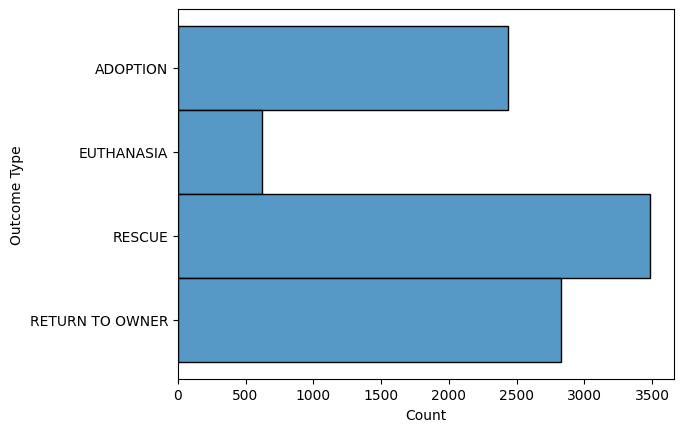

In [20]:
sns.histplot(y=df['Outcome Type'])

<Axes: xlabel='Count', ylabel='Intake Type'>

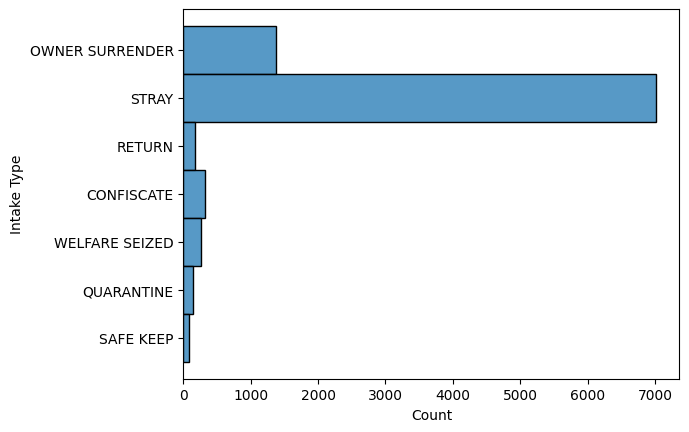

In [21]:
sns.histplot(y=df['Intake Type'])

<Axes: xlabel='Count', ylabel='Intake Condition'>

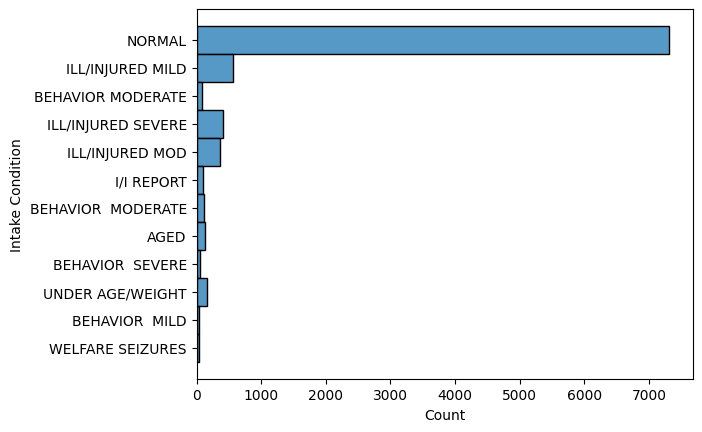

In [22]:
sns.histplot(y=df['Intake Condition'])

<Axes: xlabel='Count', ylabel='Sex'>

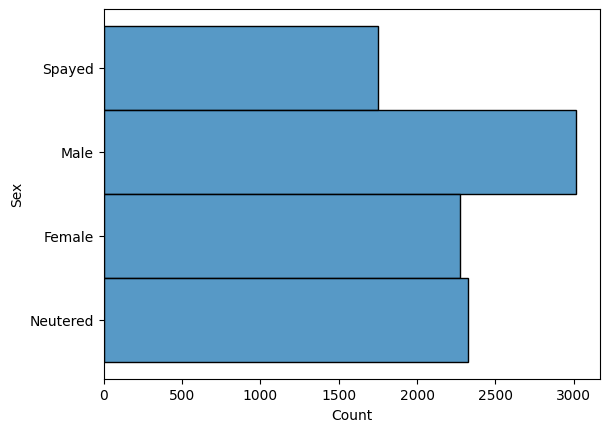

In [23]:
sns.histplot(y=df['Sex'])

<Axes: xlabel='Count', ylabel='Primary Color'>

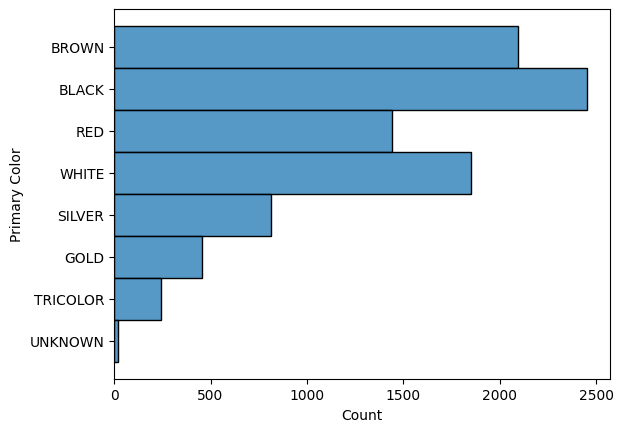

In [24]:
sns.histplot(y=df['Primary Color'])

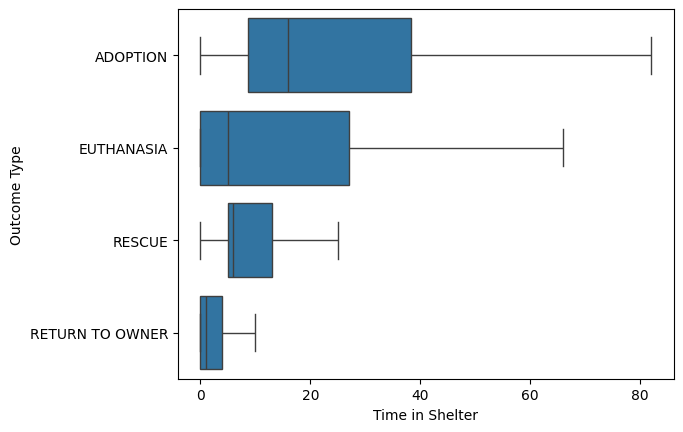

In [25]:
sns.boxplot(df, y = 'Outcome Type', x = 'Time in Shelter', showfliers = False)
plt.show()


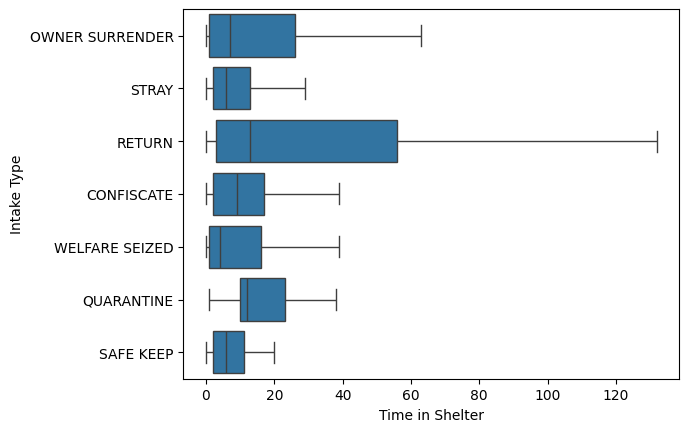

In [26]:
sns.boxplot(df, y = 'Intake Type', x = 'Time in Shelter', showfliers = False)
plt.show()


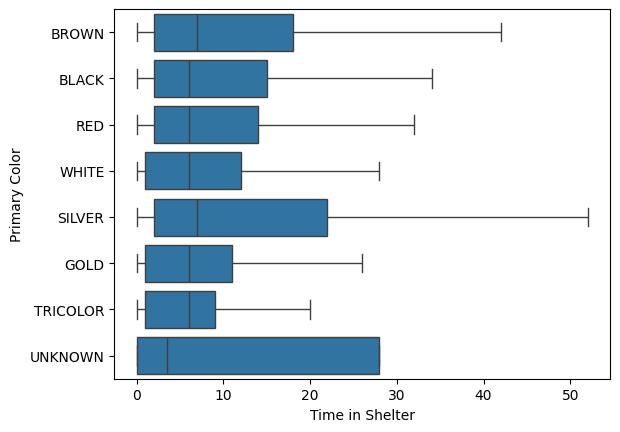

In [27]:
sns.boxplot(df, y = 'Primary Color', x = 'Time in Shelter', showfliers = False)
plt.show()


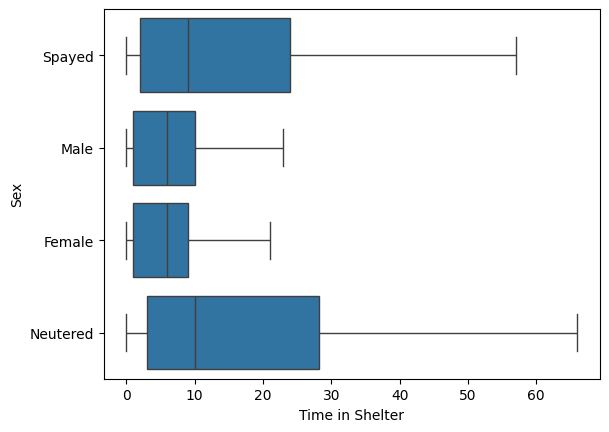

In [28]:
sns.boxplot(df, y = 'Sex', x = 'Time in Shelter', showfliers = False)
plt.show()



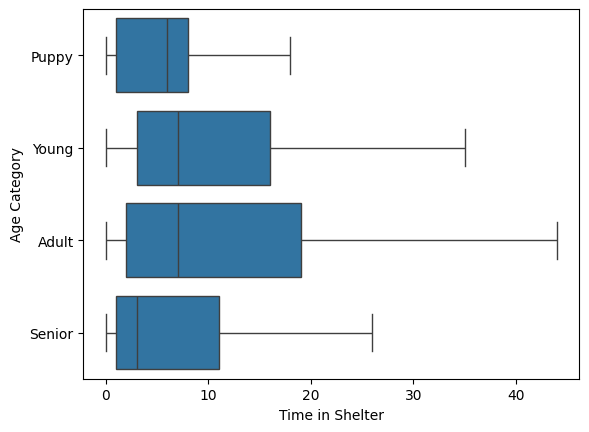

In [29]:
sns.boxplot(df, y = 'Age Category', x = 'Time in Shelter', showfliers = False)
plt.show()


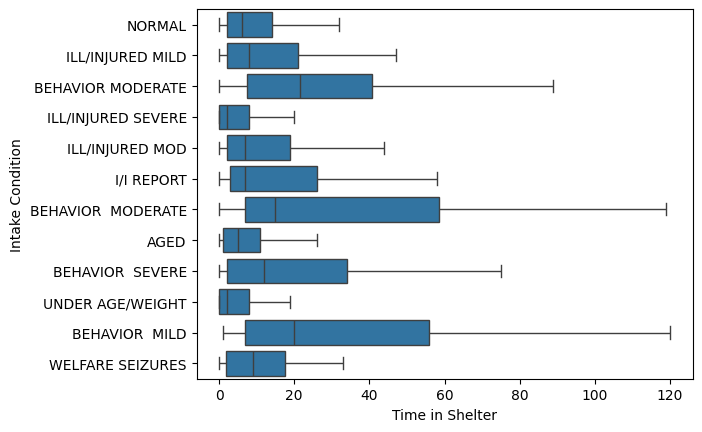

In [30]:
sns.boxplot(df, y = 'Intake Condition', x = 'Time in Shelter', showfliers = False)
plt.show()



<Axes: xlabel='Time in Shelter', ylabel='Intake Subtype'>

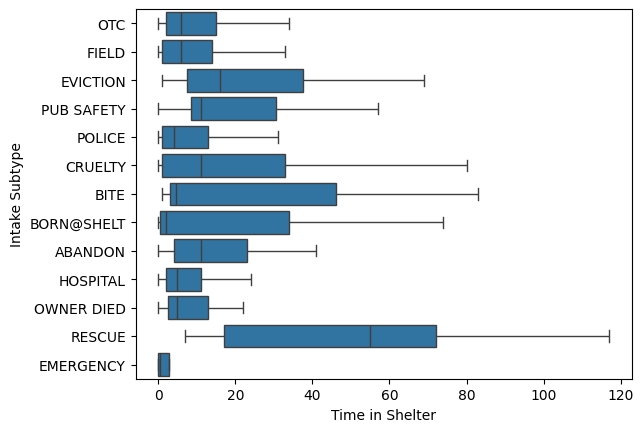

In [31]:
sns.boxplot(df, y = 'Intake Subtype', x = 'Time in Shelter', showfliers = False)


In [32]:
def frequency_table(data:pd.DataFrame, col:str, column:str):
    freq_table = pd.crosstab(index=data[col], columns=data[column], margins=True)
    rel_table = round(freq_table/freq_table.loc["All"], 2)
    return freq_table, rel_table

In [33]:
outcome_freq, outcome_rel = frequency_table(df, "Intake Type", "Outcome Type")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Outcome Type     ADOPTION  EUTHANASIA  RESCUE  RETURN TO OWNER   All
Intake Type                                                         
CONFISCATE           0.01        0.04    0.02             0.08  0.04
OWNER SURRENDER      0.15        0.35    0.21             0.02  0.15
QUARANTINE           0.00        0.05    0.00             0.03  0.01
RETURN               0.05        0.01    0.01             0.00  0.02
SAFE KEEP            0.00        0.00    0.01             0.02  0.01
STRAY                0.76        0.55    0.74             0.79  0.75
WELFARE SEIZED       0.02        0.00    0.01             0.06  0.03
All                  1.00        1.00    1.00             1.00  1.00


In [34]:
outcome_freq, outcome_rel = frequency_table(df, "Outcome Type", "Sex")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Sex              Female  Male  Neutered  Spayed   All
Outcome Type                                         
ADOPTION           0.10  0.08      0.47    0.50  0.26
EUTHANASIA         0.09  0.10      0.03    0.02  0.07
RESCUE             0.55  0.50      0.19    0.18  0.37
RETURN TO OWNER    0.27  0.32      0.31    0.31  0.30
All                1.00  1.00      1.00    1.00  1.00


In [35]:
outcome_freq, outcome_rel = frequency_table(df, "Outcome Type", "Intake Condition")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Intake Condition  AGED  BEHAVIOR  MILD  BEHAVIOR  MODERATE  BEHAVIOR  SEVERE  \
Outcome Type                                                                   
ADOPTION          0.14            0.49                0.28              0.07   
EUTHANASIA        0.10            0.15                0.17              0.52   
RESCUE            0.30            0.24                0.32              0.23   
RETURN TO OWNER   0.47            0.12                0.23              0.18   
All               1.00            1.00                1.00              1.00   

Intake Condition  BEHAVIOR MODERATE  I/I REPORT  ILL/INJURED MILD  \
Outcome Type                                                        
ADOPTION                       0.35        0.48              0.30   
EUTHANASIA                     0.15        0.10              0.07   
RESCUE                         0.27        0.26              0.37   
RETURN TO OWNER                0.23        0.16              

In [36]:
outcome_freq, outcome_rel = frequency_table(df, "Outcome Type", "Age Category")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Age Category     Puppy  Young  Adult  Senior   All
Outcome Type                                      
ADOPTION          0.24   0.33   0.24    0.11  0.26
EUTHANASIA        0.03   0.05   0.08    0.11  0.07
RESCUE            0.65   0.36   0.35    0.29  0.37
RETURN TO OWNER   0.07   0.27   0.33    0.49  0.30
All               1.00   1.00   1.00    1.00  1.00


In [37]:
outcome_freq, outcome_rel = frequency_table(df, "Outcome Type", "Primary Color")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Primary Color    BLACK  BROWN  GOLD   RED  SILVER  TRICOLOR  UNKNOWN  WHITE  \
Outcome Type                                                                  
ADOPTION          0.26   0.27  0.22  0.28    0.29      0.16     0.10   0.24   
EUTHANASIA        0.06   0.08  0.04  0.05    0.12      0.05     0.05   0.06   
RESCUE            0.38   0.37  0.38  0.38    0.26      0.45     0.70   0.39   
RETURN TO OWNER   0.30   0.28  0.36  0.29    0.33      0.35     0.15   0.31   
All               1.00   1.00  1.00  1.00    1.00      1.00     1.00   1.00   

Primary Color     All  
Outcome Type           
ADOPTION         0.26  
EUTHANASIA       0.07  
RESCUE           0.37  
RETURN TO OWNER  0.30  
All              1.00  


In [38]:
outcome_freq, outcome_rel = frequency_table(df, "Age Category", "Intake Condition")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Intake Condition  AGED  BEHAVIOR  MILD  BEHAVIOR  MODERATE  BEHAVIOR  SEVERE  \
Age Category                                                                   
Puppy             0.00            0.02                0.00              0.00   
Young             0.02            0.34                0.46              0.38   
Adult             0.12            0.54                0.47              0.49   
Senior            0.86            0.10                0.07              0.13   
All               1.00            1.00                1.00              1.00   

Intake Condition  BEHAVIOR MODERATE  I/I REPORT  ILL/INJURED MILD  \
Age Category                                                        
Puppy                          0.01        0.14              0.10   
Young                          0.38        0.49              0.32   
Adult                          0.52        0.25              0.35   
Senior                         0.09        0.12              

In [39]:
outcome_freq, outcome_rel = frequency_table(df, "Age Category", "Intake Type")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Intake Type   CONFISCATE  OWNER SURRENDER  QUARANTINE  RETURN  SAFE KEEP  \
Age Category                                                               
Puppy               0.06             0.11        0.02    0.04       0.05   
Young               0.39             0.36        0.48    0.58       0.23   
Adult               0.41             0.34        0.37    0.32       0.52   
Senior              0.14             0.19        0.12    0.06       0.20   
All                 1.00             1.00        1.00    1.00       1.00   

Intake Type   STRAY  WELFARE SEIZED   All  
Age Category                               
Puppy          0.09            0.10  0.09  
Young          0.42            0.44  0.42  
Adult          0.35            0.32  0.35  
Senior         0.13            0.13  0.14  
All            1.00            1.00  1.00  


In [40]:
outcome_freq, outcome_rel = frequency_table(df, "Sex", "Intake Type")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Intake Type  CONFISCATE  OWNER SURRENDER  QUARANTINE  RETURN  SAFE KEEP  \
Sex                                                                       
Female             0.23             0.22        0.18    0.10       0.15   
Male               0.34             0.28        0.40    0.13       0.23   
Neutered           0.23             0.28        0.31    0.47       0.35   
Spayed             0.21             0.22        0.10    0.30       0.27   
All                1.00             1.00        1.00    1.00       1.00   

Intake Type  STRAY  WELFARE SEIZED   All  
Sex                                       
Female        0.25            0.28  0.24  
Male          0.33            0.28  0.32  
Neutered      0.23            0.26  0.25  
Spayed        0.18            0.18  0.19  
All           1.00            1.00  1.00  


In [41]:
outcome_freq, outcome_rel = frequency_table(df, "Sex", "Intake Condition")

print("Two-way relative frequency table")
print(outcome_rel)

Two-way relative frequency table
Intake Condition  AGED  BEHAVIOR  MILD  BEHAVIOR  MODERATE  BEHAVIOR  SEVERE  \
Sex                                                                            
Female            0.20            0.24                0.12              0.20   
Male              0.28            0.17                0.30              0.39   
Neutered          0.35            0.41                0.37              0.26   
Spayed            0.17            0.17                0.22              0.15   
All               1.00            1.00                1.00              1.00   

Intake Condition  BEHAVIOR MODERATE  I/I REPORT  ILL/INJURED MILD  \
Sex                                                                 
Female                         0.12        0.28              0.22   
Male                           0.24        0.23              0.29   
Neutered                       0.39        0.26              0.28   
Spayed                         0.24        0.24              

# Optimized Model

Upsampled random forest and downsampled naive bayes performed best. Prefer random forest because upsampling does not lose data. Eliminated dogs that were returned to their original owners because the inclusion of that category decreased the power of the model. Those dogs also had short shelter stays and were likely within or nearly within the typical stray hold period. 79% of dogs that were returned to their owners were strays.
## Top Features
The top attributes that increase the accuracy of the model are sex (.25) and intake condition (.11) as measured by permutation importance. The relative frequency tables show that the most frequent outcome for spayed and neutered dogs is adoption and for unspayed/neutered is rescue. 

In [42]:


# adding dummy variables


x = df[['Primary Color', 'Secondary Color', 'Sex', 'Intake Subtype', 'Intake Condition', 'Intake Type', 'Age on Intake']]
y = df['Outcome Type']



x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, train_size = 0.8, random_state = 42, stratify = y)

train = x_train.copy()
test = x_test.copy()
train['Outcome Type'] = y_train
test['Outcome Type'] = y_test

#Up sampling

adoption = train[train['Outcome Type'] == 'ADOPTION']
euthanasia = train[train['Outcome Type'] == 'EUTHANASIA']
rescue = train[train['Outcome Type'] == 'RESCUE']

euthanasia = resample(euthanasia, n_samples = 2000)
train = pd.concat([adoption, euthanasia, rescue])

adoption = test[test['Outcome Type'] == 'ADOPTION']
euthanasia = test[test['Outcome Type'] == 'EUTHANASIA']
rescue = test[test['Outcome Type'] == 'RESCUE']

euthanasia = resample(euthanasia, n_samples = 480)
test = pd.concat([adoption, euthanasia, rescue])

x_train = train[['Primary Color', 'Secondary Color', 'Sex', 'Intake Subtype', 'Intake Condition', 'Intake Type', 'Age on Intake']]
y_train = train['Outcome Type']

x_test = test[['Primary Color', 'Secondary Color', 'Sex', 'Intake Subtype', 'Intake Condition', 'Intake Type', 'Age on Intake']]
y_test = test['Outcome Type']

x_train = pd.get_dummies(x_train, dtype = np.int64, drop_first = True)
x_test = pd.get_dummies(x_test, dtype = np.int64, drop_first = True)

Text(70.72222222222221, 0.5, 'Predicted')

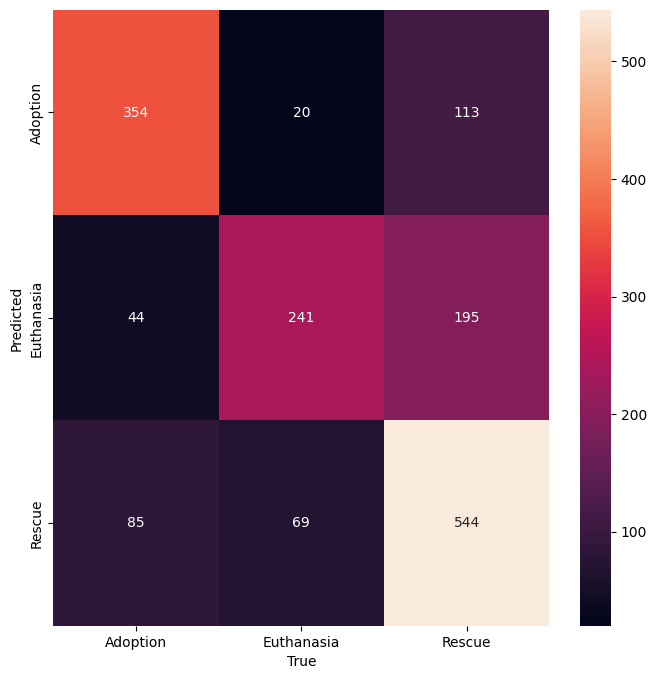

In [43]:
best = RandomForestClassifier(criterion = 'gini', max_depth = 10, random_state = 42).fit(x_train, y_train)
predictedrf = best.predict(x_test)
conf_matrix = confusion_matrix(y_test, predictedrf)
labels = ['Adoption', 'Euthanasia', 'Rescue']
plt.subplots(figsize =(8,8))
sns.heatmap(conf_matrix, annot = True, fmt = '.0f', xticklabels = labels, yticklabels = labels)
plt.xlabel('True')
plt.ylabel('Predicted')

In [44]:
print(sklearn.metrics.classification_report(y_test, predictedrf))

              precision    recall  f1-score   support

    ADOPTION       0.73      0.73      0.73       487
  EUTHANASIA       0.73      0.50      0.60       480
      RESCUE       0.64      0.78      0.70       698

    accuracy                           0.68      1665
   macro avg       0.70      0.67      0.68      1665
weighted avg       0.69      0.68      0.68      1665



In [45]:
best.estimators_[0].get_depth()

10

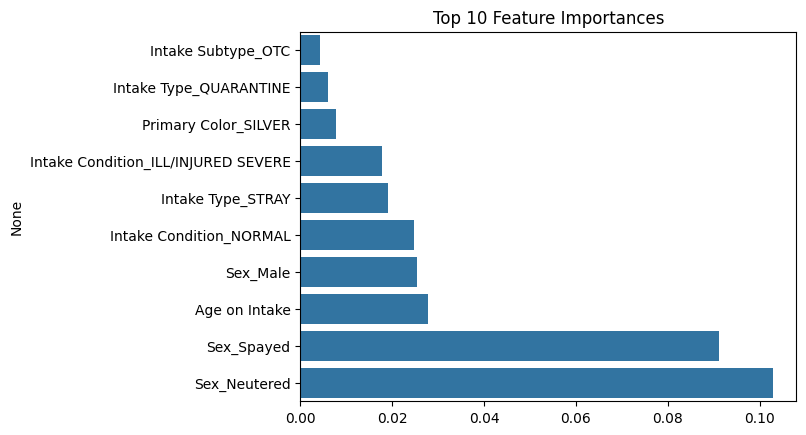

In [46]:
from sklearn.inspection import permutation_importance

result = permutation_importance(best, x_test, y_test, n_repeats = 10)
feature_importances = pd.Series(result.importances_mean, index = x_test.columns)
sorted_feature_importances = feature_importances.sort_values()[-10:]
sns.barplot(x = sorted_feature_importances.values, y = sorted_feature_importances.index, orient = 'h')
plt.title('Top 10 Feature Importances')
plt.show()


In [47]:

dfpi = pd.DataFrame({'Feature': x_test.columns, 'Mean': np.round(result.importances_mean, 2), 'STD': result.importances_std})
dfpi.sort_values(by=['Mean'], ascending = False)

Feature  Mean       STD
15                         Sex_Neutered  0.10  0.006831
16                           Sex_Spayed  0.09  0.005488
0                         Age on Intake  0.03  0.005778
14                             Sex_Male  0.03  0.003146
43                    Intake Type_STRAY  0.02  0.003273
36              Intake Condition_NORMAL  0.02  0.005280
35  Intake Condition_ILL/INJURED SEVERE  0.02  0.003913
4                  Primary Color_SILVER  0.01  0.001908
40               Intake Type_QUARANTINE  0.01  0.000849
27                Intake Subtype_RESCUE  0.00  0.000000
28      Intake Condition_BEHAVIOR  MILD -0.00  0.000000
29  Intake Condition_BEHAVIOR  MODERATE -0.00  0.000385
30    Intake Condition_BEHAVIOR  SEVERE  0.00  0.000851
31   Intake Condition_BEHAVIOR MODERATE -0.00  0.000269
32          Intake Condition_I/I REPORT  0.00  0.000499
34     Intake Condition_ILL/INJURED MOD -0.00  0.001047
33    Intake Condition_ILL/INJURED MILD -0.00  0.001375
25                Intake Subtype_POLICE  0.00  0.000360
37    Intake Condition_UNDER AGE/WEIGHT  0.00  0.001012
38    Intake Condition_WELFARE SEIZURES  0.00  0.000000
39          Intake Type_OWNER SURRENDER  0.00  0.002433
41                   Intake Type_RETURN  0.00  0.000541
42                Intake Type_SAFE KEEP  0.00  0.000000
26            Intake Subtype_PUB SAFETY  0.00  0.000360
22              Intake Subtype_HOSPITAL  0.00  0.000420
24            Intake Subtype_OWNER DIED  0.00  0.000180
23                   Intake Subtype_OTC  0.00  0.002112
2                    Primary Color_GOLD -0.00  0.000883
3                     Primary Color_RED -0.00  0.001952
5                Primary Color_TRICOLOR  0.00  0.000970
6                 Primary Color_UNKNOWN  0.00  0.000000
7                   Primary Color_WHITE  0.00  0.002112
8                 Secondary Color_BROWN  0.00  0.000923
9                  Secondary Color_GOLD  0.00  0.000323
10                  Secondary Color_RED  0.00  0.001491
11               Secondary Color_SILVER -0.00  0.000420
12             Secondary Color_TRICOLOR -0.00  0.000180
13                Secondary Color_WHITE  0.00  0.002512
17                  Intake Subtype_BITE  0.00  0.000000
18            Intake Subtype_BORN@SHELT  0.00  0.000000
19               Intake Subtype_CRUELTY  0.00  0.000000
20              Intake Subtype_EVICTION -0.00  0.000180
21                 Intake Subtype_FIELD  0.00  0.002740
1                   Primary Color_BROWN  0.00  0.001770
44           Intake Type_WELFARE SEIZED  0.00  0.000612

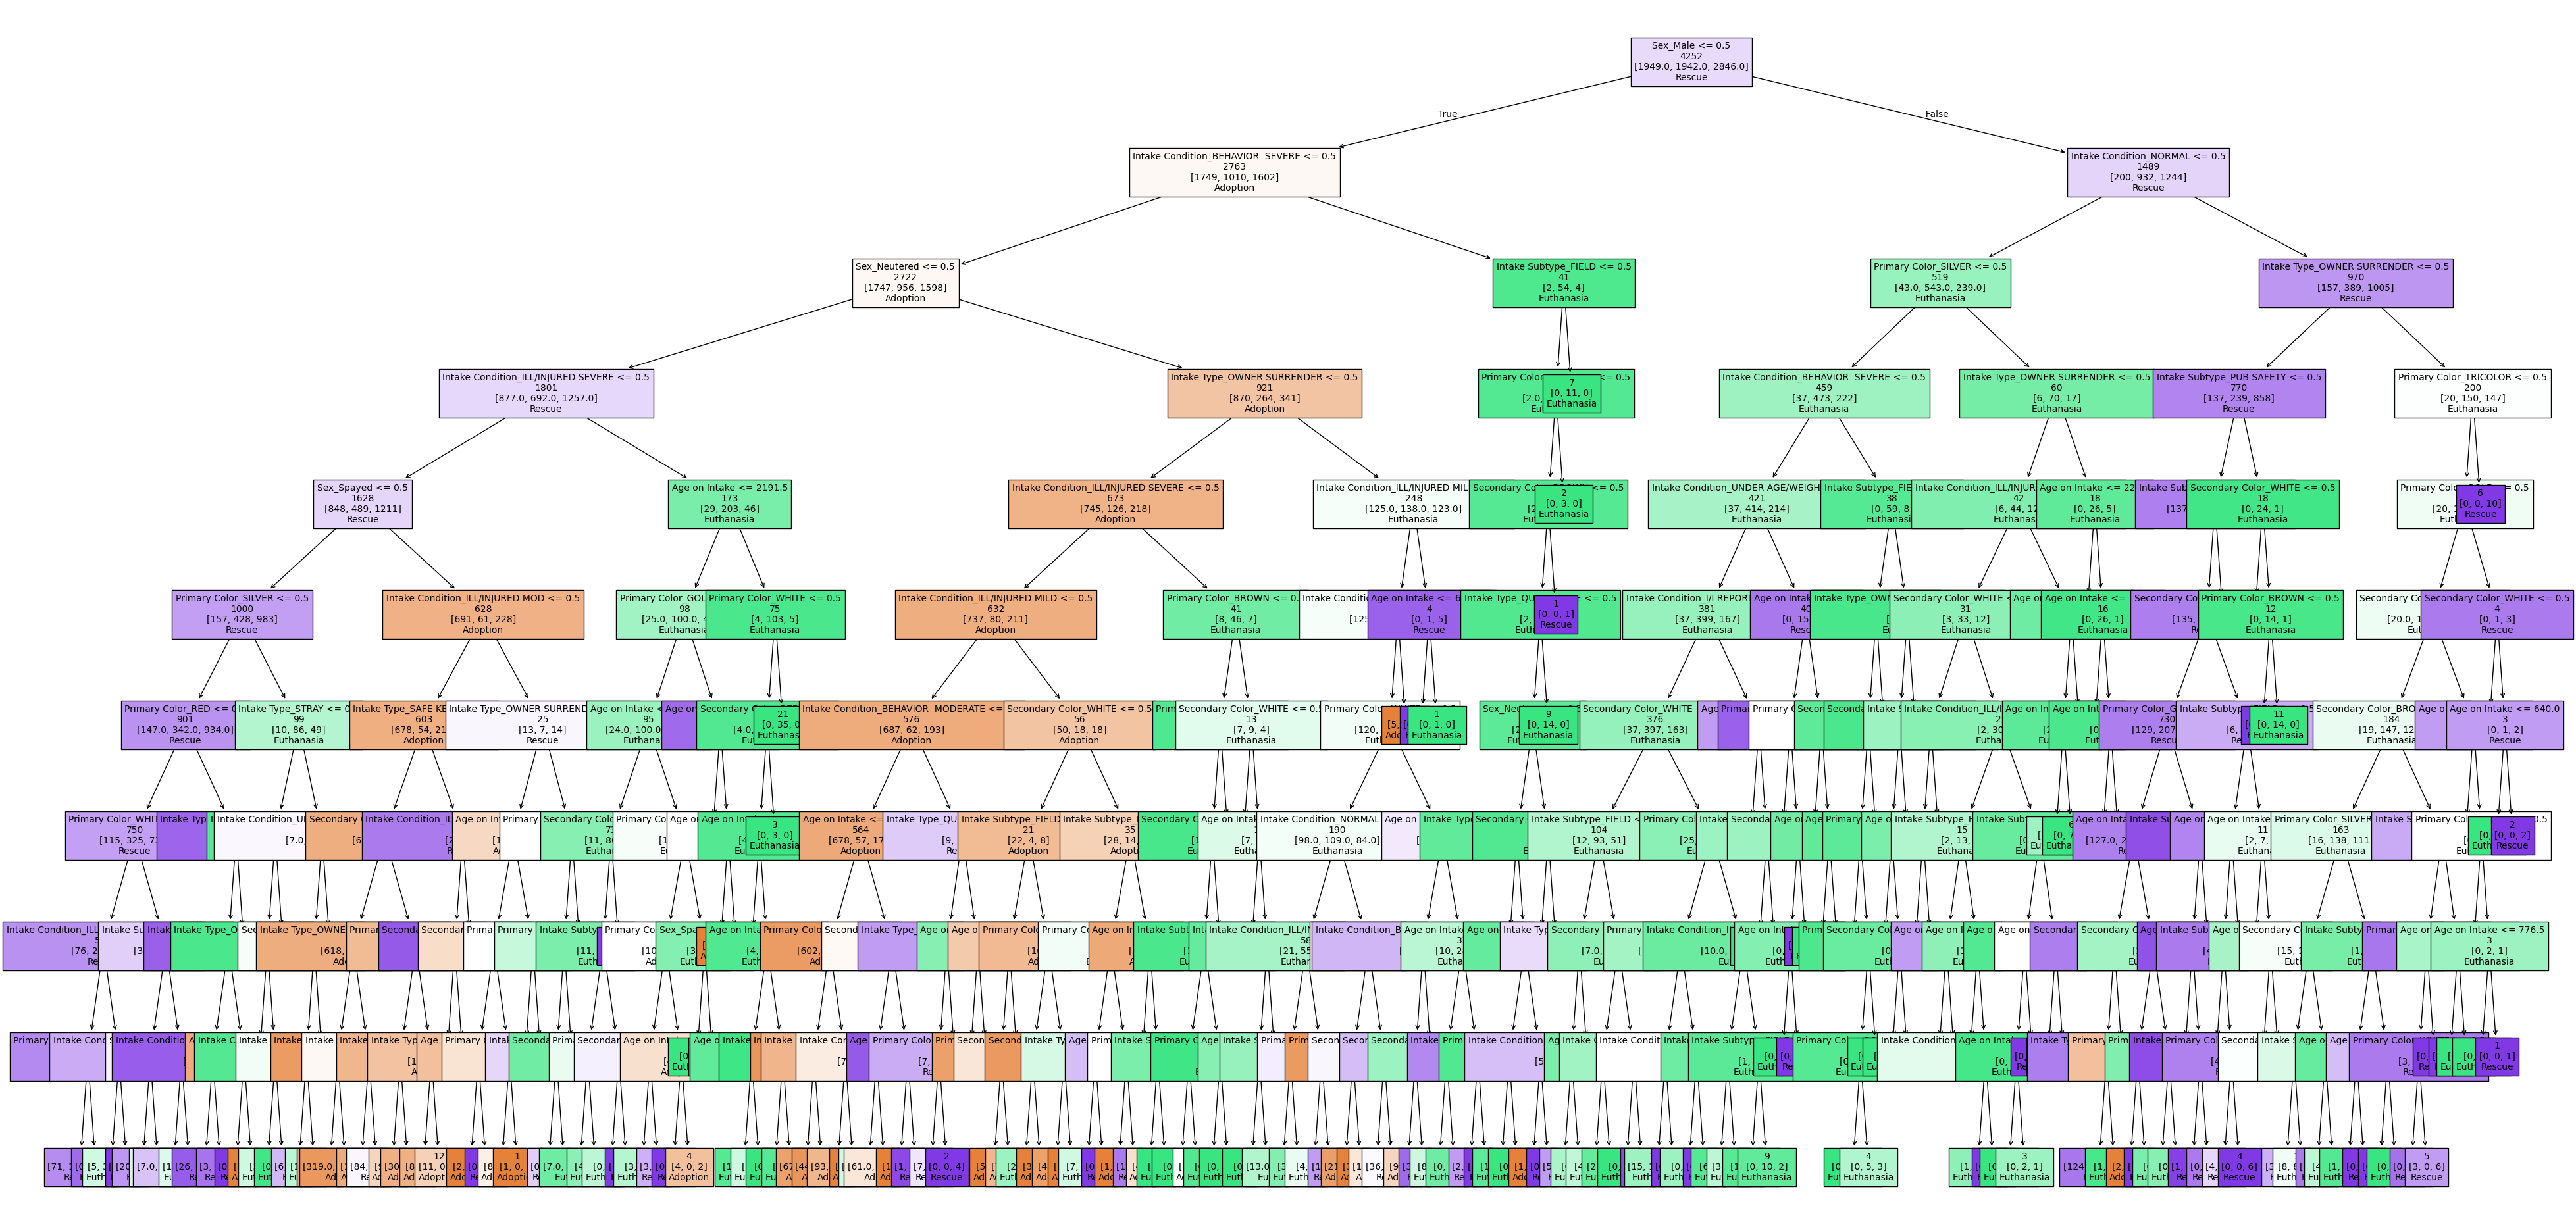

In [48]:
plt.figure(figsize = (48,24))
tree.plot_tree(best.estimators_[0], feature_names = x_test.columns, label = 'none', impurity = False, 
               filled = True, class_names = ['Adoption', 'Euthanasia', 'Rescue'], fontsize = 10)
plt.savefig('tree_high_dpi', dpi = 100)

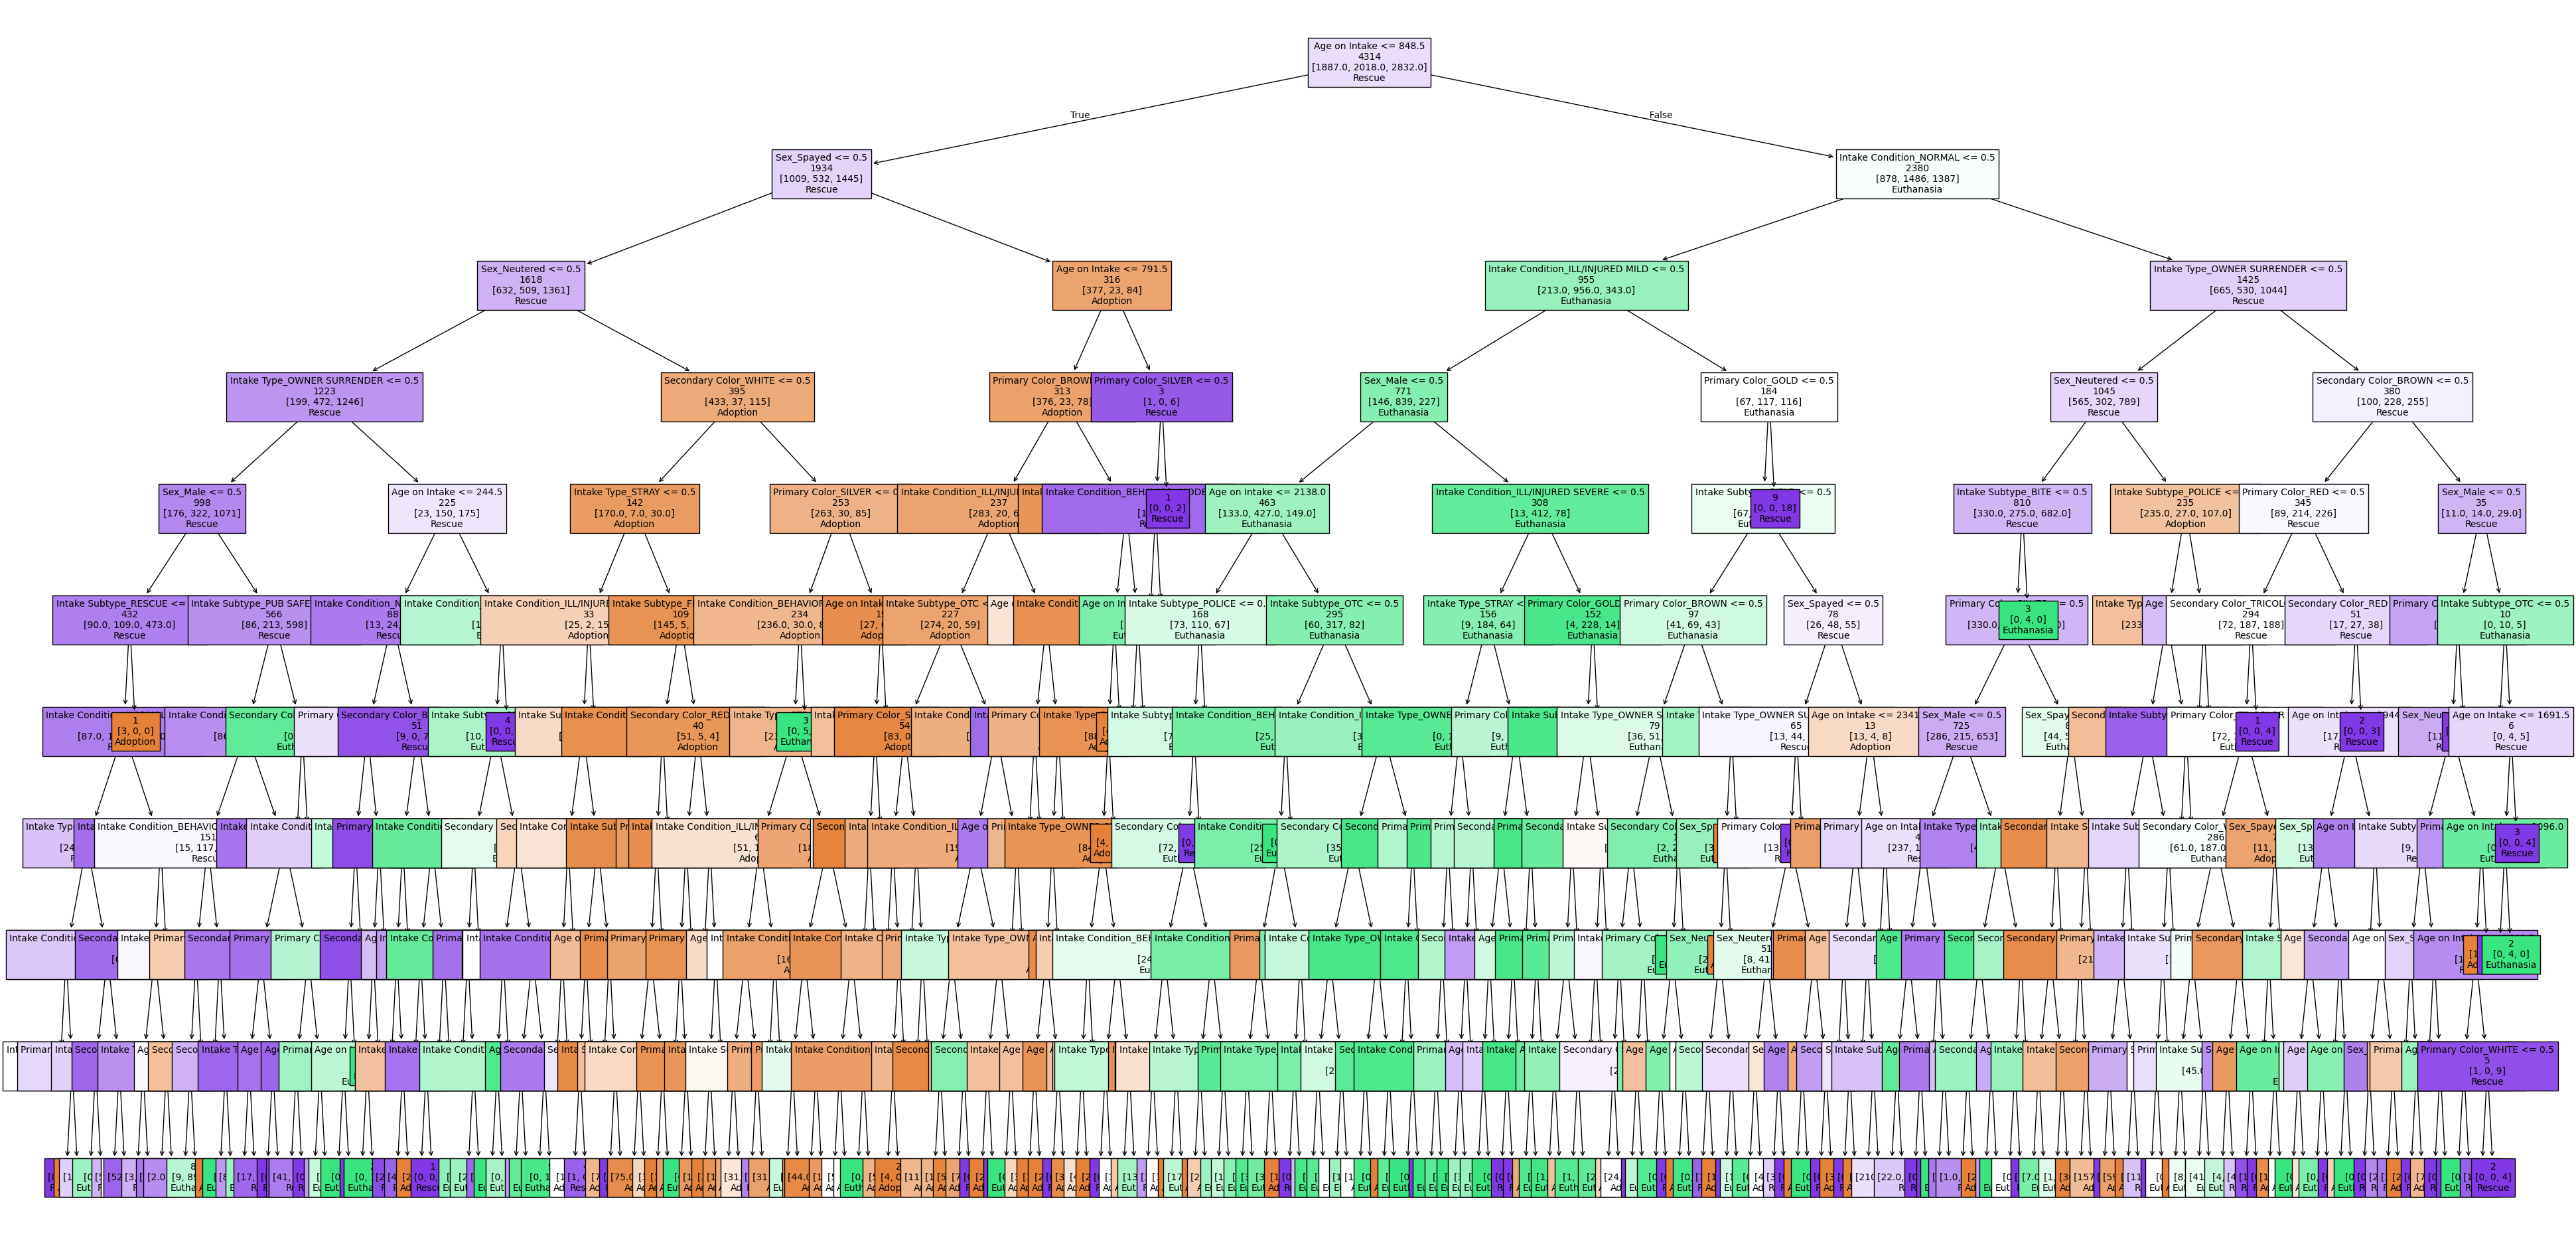

In [49]:
plt.figure(figsize = (48,24))
tree.plot_tree(best.estimators_[50], feature_names = x_test.columns, label = 'none', impurity = False, 
               filled = True, class_names = ['Adoption', 'Euthanasia', 'Rescue'], fontsize = 10)
plt.savefig('tree_high_dpi2', dpi = 100)

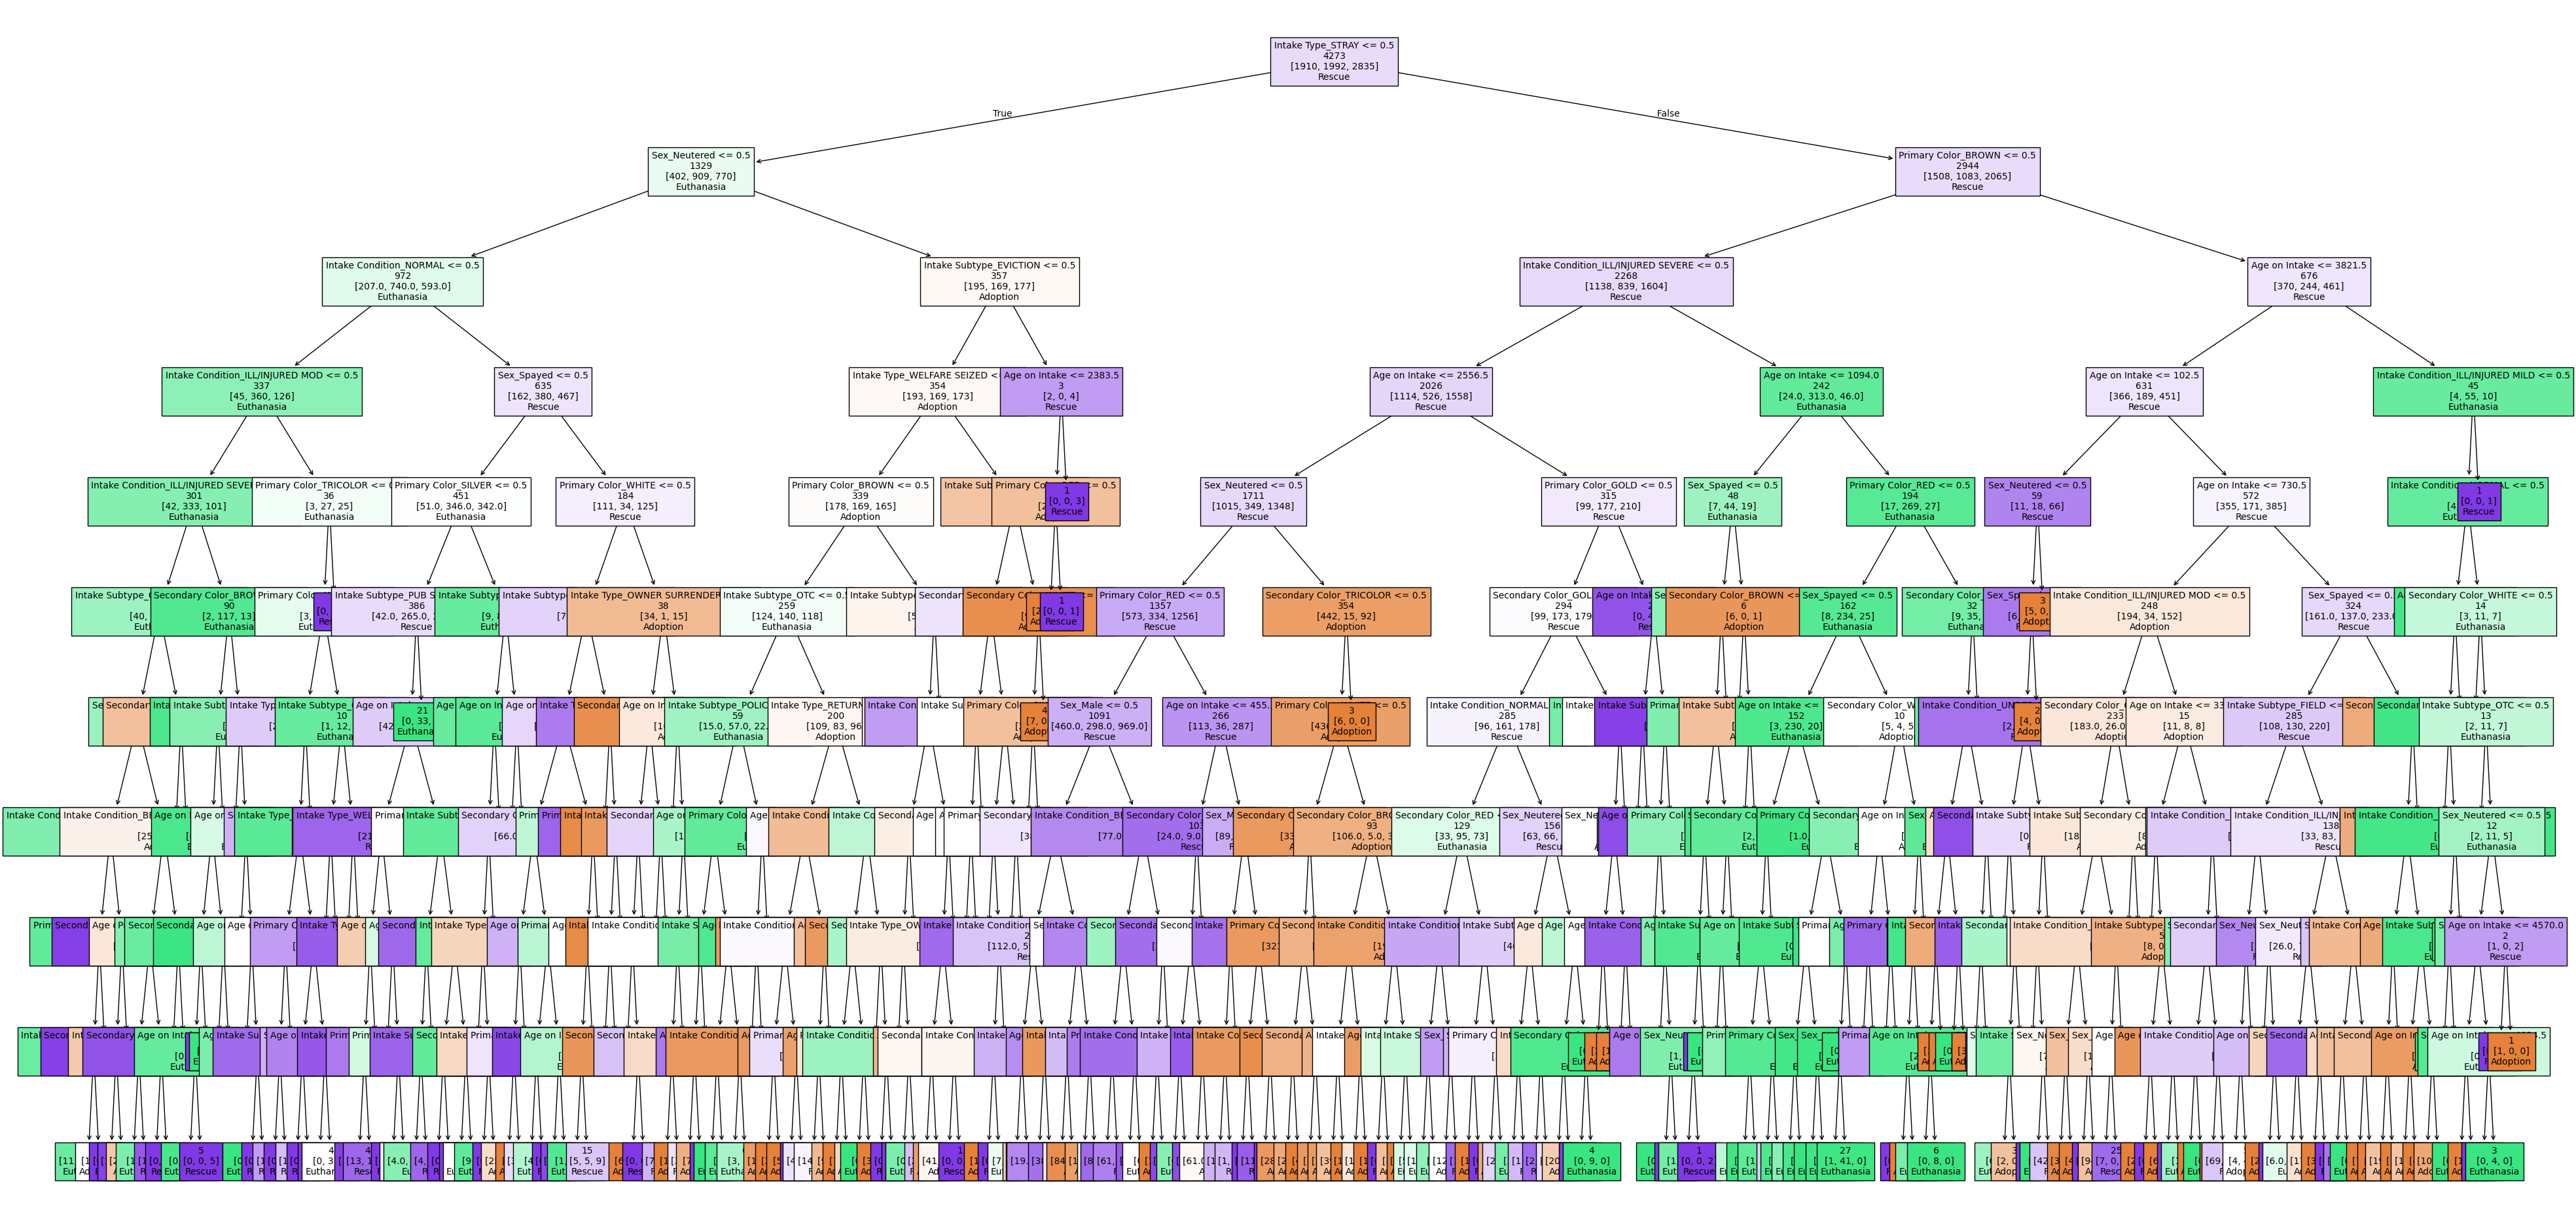

In [50]:
plt.figure(figsize = (48,24))
tree.plot_tree(best.estimators_[90], feature_names = x_test.columns, label = 'none', impurity = False, 
               filled = True, class_names = ['Adoption', 'Euthanasia', 'Rescue'], fontsize = 10)
plt.savefig('tree_high_dpi3', dpi = 100)

In [51]:

columns = x_test.columns
test = pd.DataFrame(columns = columns)
# brown and white neutered male stray mild ill
test.loc[0] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
test.loc[1] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
test.loc[2] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
test.loc[3] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]# adding a row
test.loc[4] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0]
test.loc[5] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0]
test.loc[6] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0]
test.loc[7] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]


ValueError: cannot set a row with mismatched columns

In [ ]:
best.predict(test)

In [ ]:
x_test.columns